# Hierarchical Clustering

## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import procyclingstats as pcs
import umap

from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

# Otherwise nothing will be found
sys.path.append(os.path.abspath(os.path.join('..')))

from utility.cluster_utility import scale_data, hier_search

c:\Users\Yuri\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Global variables, constants, etc.

In [3]:
sys.path.append('../dataset/')
sys.path.append('../utility/')

# Global variables, constants
IMAGE_DIR = '../images/'
RANDOM_STATE = 42
hyperparametrs = {
    'n_clusters': np.arange(2, 21),
    'linkage': ['single', 'complete', 'average', 'ward']
}

We've spent a lot of effort into engineering new features, understanding them, etc. Whether we've done this well and whether is enough it's a different story.

The point here is that - after the understanding, engineering and transformation - we have some cleaned-up versions of the datasets.

In [4]:
cyclists_df = pd.read_csv('../dataset/cyclists_cleaned.csv')
races_df = pd.read_csv('../dataset/races_cleaned.csv')

Let's reduce the dimensionality of the dataset by dropping useless or non-descriptive columns.

In [5]:
cyclists_df = cyclists_df.select_dtypes(include=[np.number])
cyclists_df = cyclists_df.drop(columns=['birth_year', 'weight', 'height', 'avg_points_per_race', 'total_points'])
cyclists_df = cyclists_df.dropna()

Let's scale the data

In [7]:
cyc_normalizer, cyc_normalized = scale_data(cyclists_df)

Let's check how the silhouette scores for the selected linkage types and maximum clusters compare

In [8]:
silhouettes = hier_search(hyperparametrs, cyc_normalized)

c:\Users\Yuri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 76 is smaller than n_iter=80. Running 76 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Let's plot them

In [10]:
silhouettes

,n_clusters,linkage,random_state,silhouette
0,2,single,42,0.898002
38,2,average,42,0.898002
19,2,complete,42,0.885166
1,3,single,42,0.867848
2,4,single,42,0.852579
...,...,...,...,...
64,9,ward,42,0.105433
63,8,ward,42,0.098308
66,11,ward,42,0.097490
75,20,ward,42,0.095825


Looks like the best silhouette score is reached by both single and average linkages with 2 clusters. Let's try to plot them

In [9]:
single_linkage = AgglomerativeClustering(n_clusters=2, linkage='single')
average_linkage = AgglomerativeClustering(n_clusters=2, linkage='average')

In [10]:
labels_single = single_linkage.fit_predict(cyc_normalized)
labels_average = average_linkage.fit_predict(cyc_normalized)

In [11]:
cyclists_df['single'] = labels_single

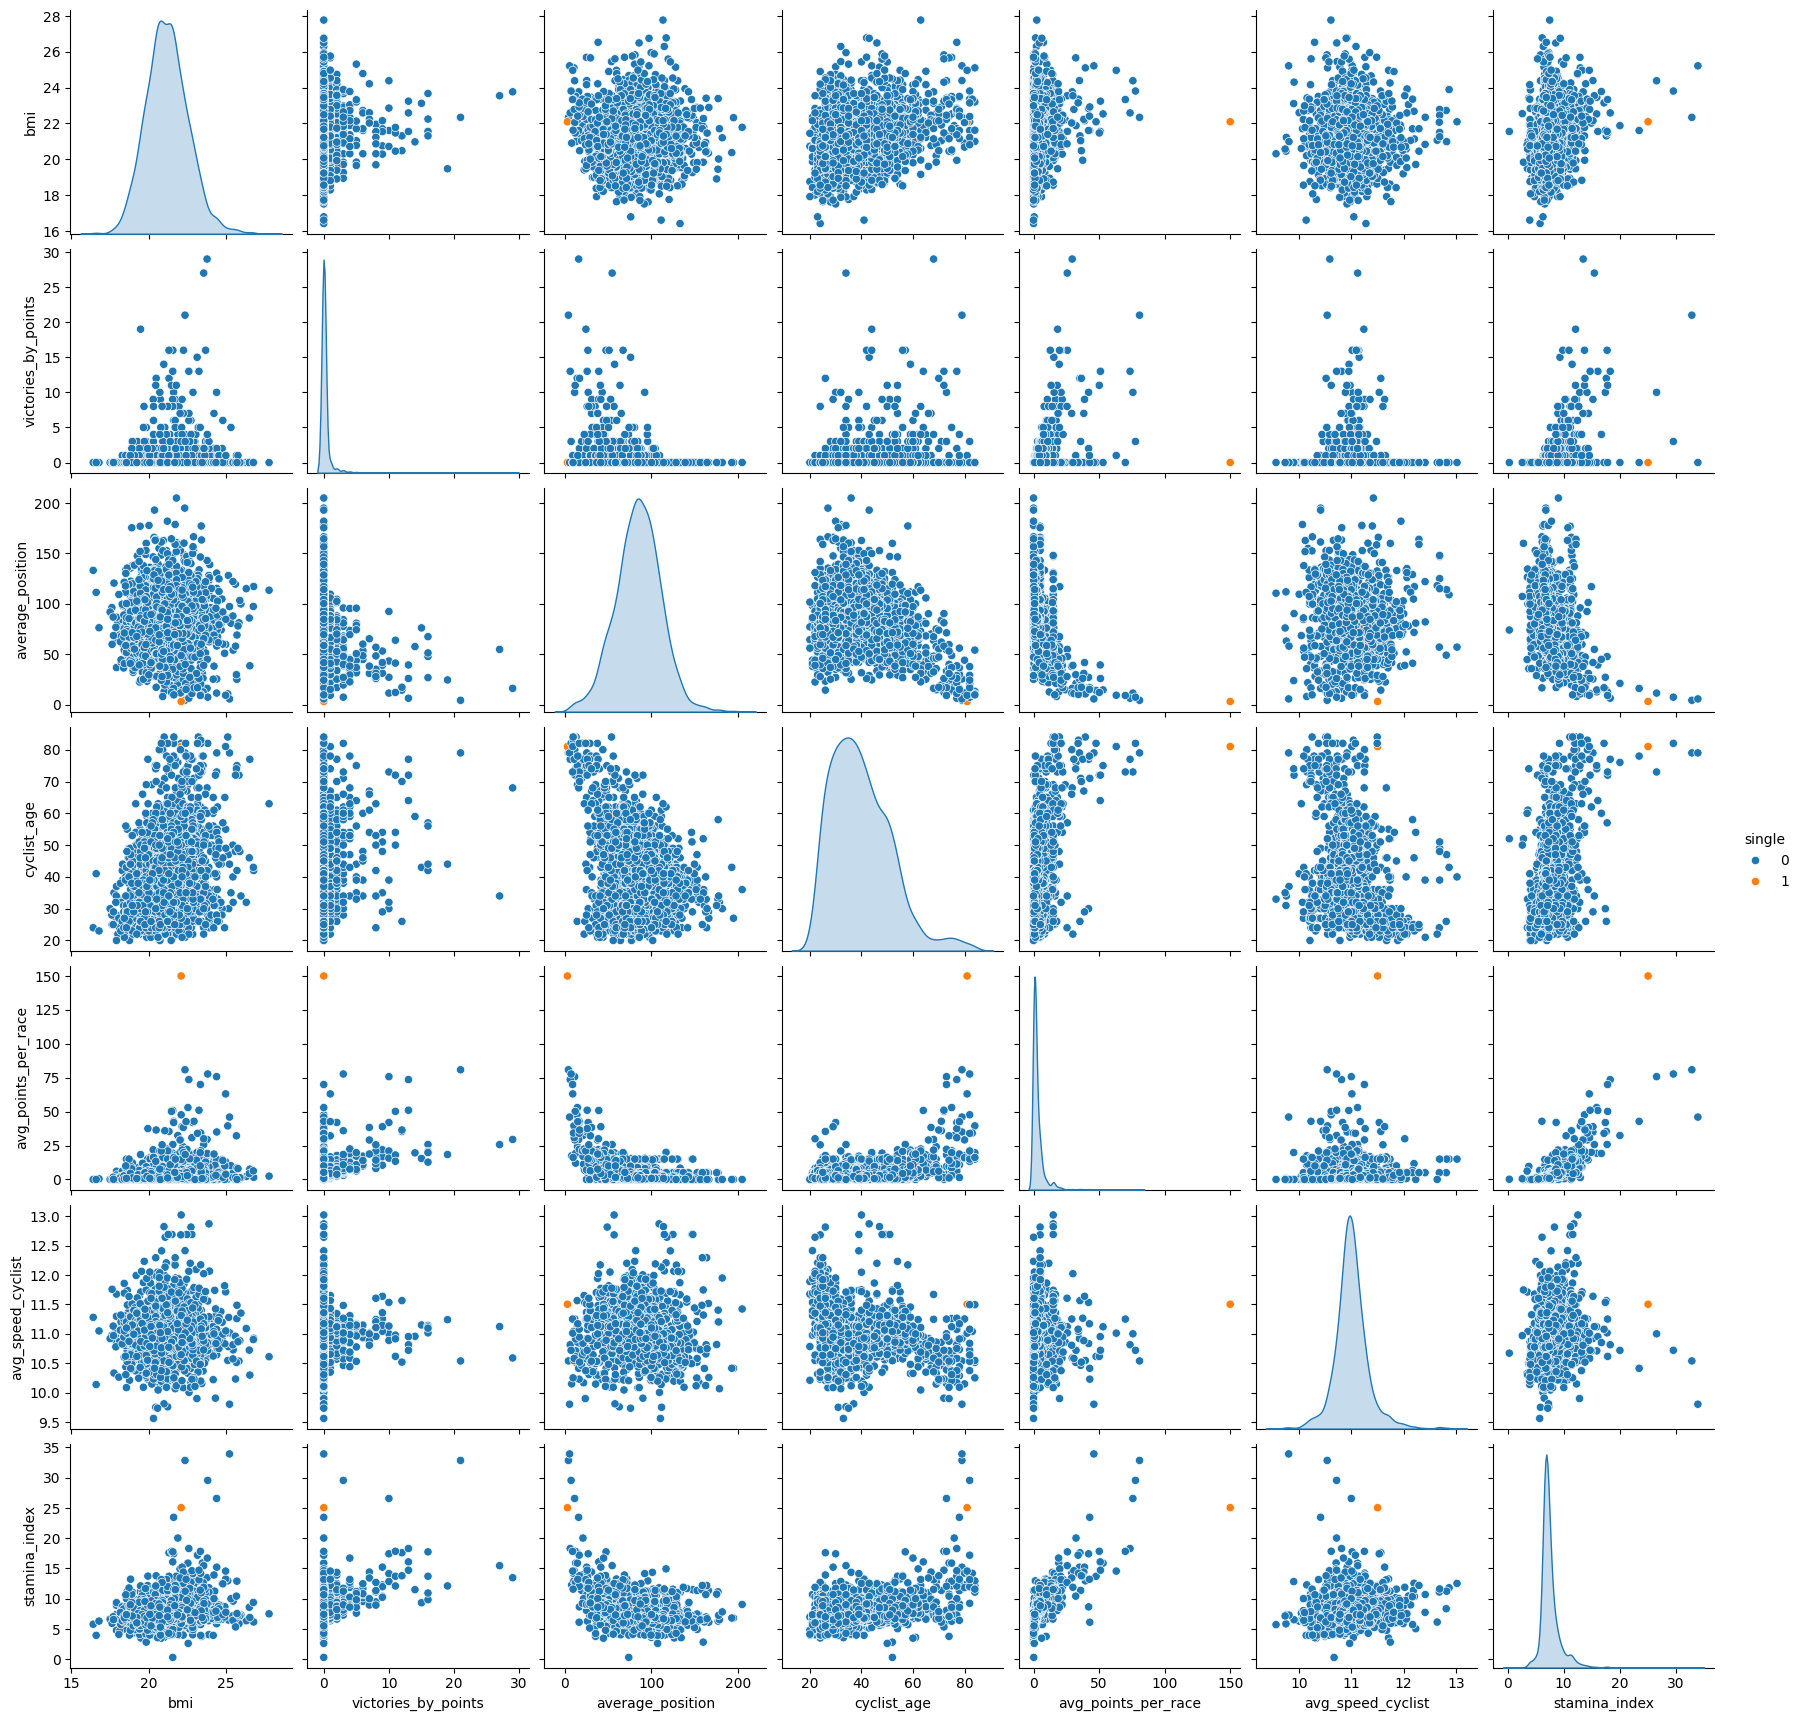

In [12]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='single')
plt.show()

In [28]:
reducer = umap.UMAP(n_neighbors=15, learning_rate=0.1, n_components=3, random_state=RANDOM_STATE)

In [29]:
reduced_data = reducer.fit_transform(cyclists_df)

c:\Users\Yuri\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [35]:
import plotly.express as px
import pandas as pd

# Prepare data for Plotly
df = pd.DataFrame({
    'UMAP 1': reduced_data[:, 0],
    'UMAP 2': reduced_data[:, 1],
    'UMAP 3': reduced_data[:, 2],
    'Cluster': labels_full
})

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    df,
    x='UMAP 1',
    y='UMAP 2',
    z='UMAP 3',
    color='Cluster',
    title='UMAP 3D',
    color_continuous_scale='Viridis'
)

# Show the interactive plot
fig.show()


In [37]:
single_linkage.fit_predict(reduced_data)

array([0, 1, 1, ..., 1, 4, 1], dtype=int64)

In [38]:
import plotly.express as px
import pandas as pd

# Prepare data for Plotly
df = pd.DataFrame({
    'UMAP 1': reduced_data[:, 0],
    'UMAP 2': reduced_data[:, 1],
    'UMAP 3': reduced_data[:, 2],
    'Cluster': single_linkage.labels_
})

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    df,
    x='UMAP 1',
    y='UMAP 2',
    z='UMAP 3',
    color='Cluster',
    title='UMAP 3D',
    color_continuous_scale='Viridis'
)

# Show the interactive plot
fig.show()


In [41]:
# apply labels to the cyclists dataframe
#  cyclists_df['cluster'] = single_linkage.labels_
cyclists_df['cluster'] = labels_full

In [48]:
cyclists_df.groupby('cluster').mean()

,bmi,victories_by_points,average_position,cyclist_age,avg_points_per_race,avg_speed_cyclist,stamina_index
cluster,,,,,,,
0,23.178488,7.000000,8.144070,77.285714,74.418421,10.927001,29.978223
1,21.141501,0.210526,84.366642,39.025945,2.351538,11.008394,7.365074
2,21.156879,0.000000,145.297458,35.555556,2.101867,10.987219,7.442729
3,22.093170,0.000000,3.000000,81.000000,150.000000,11.503743,25.047306
4,22.083346,2.886364,26.469212,69.329545,21.324537,10.763044,11.805288
5,21.895023,7.800000,29.919076,26.200000,34.359570,11.673552,14.966487
